In [28]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import h5py
from scipy import ndimage
from lr_utils import load_dataset

X_train_set, y_train, X_test_set, y_test, classes = load_dataset()

## **Overview the Dataset**

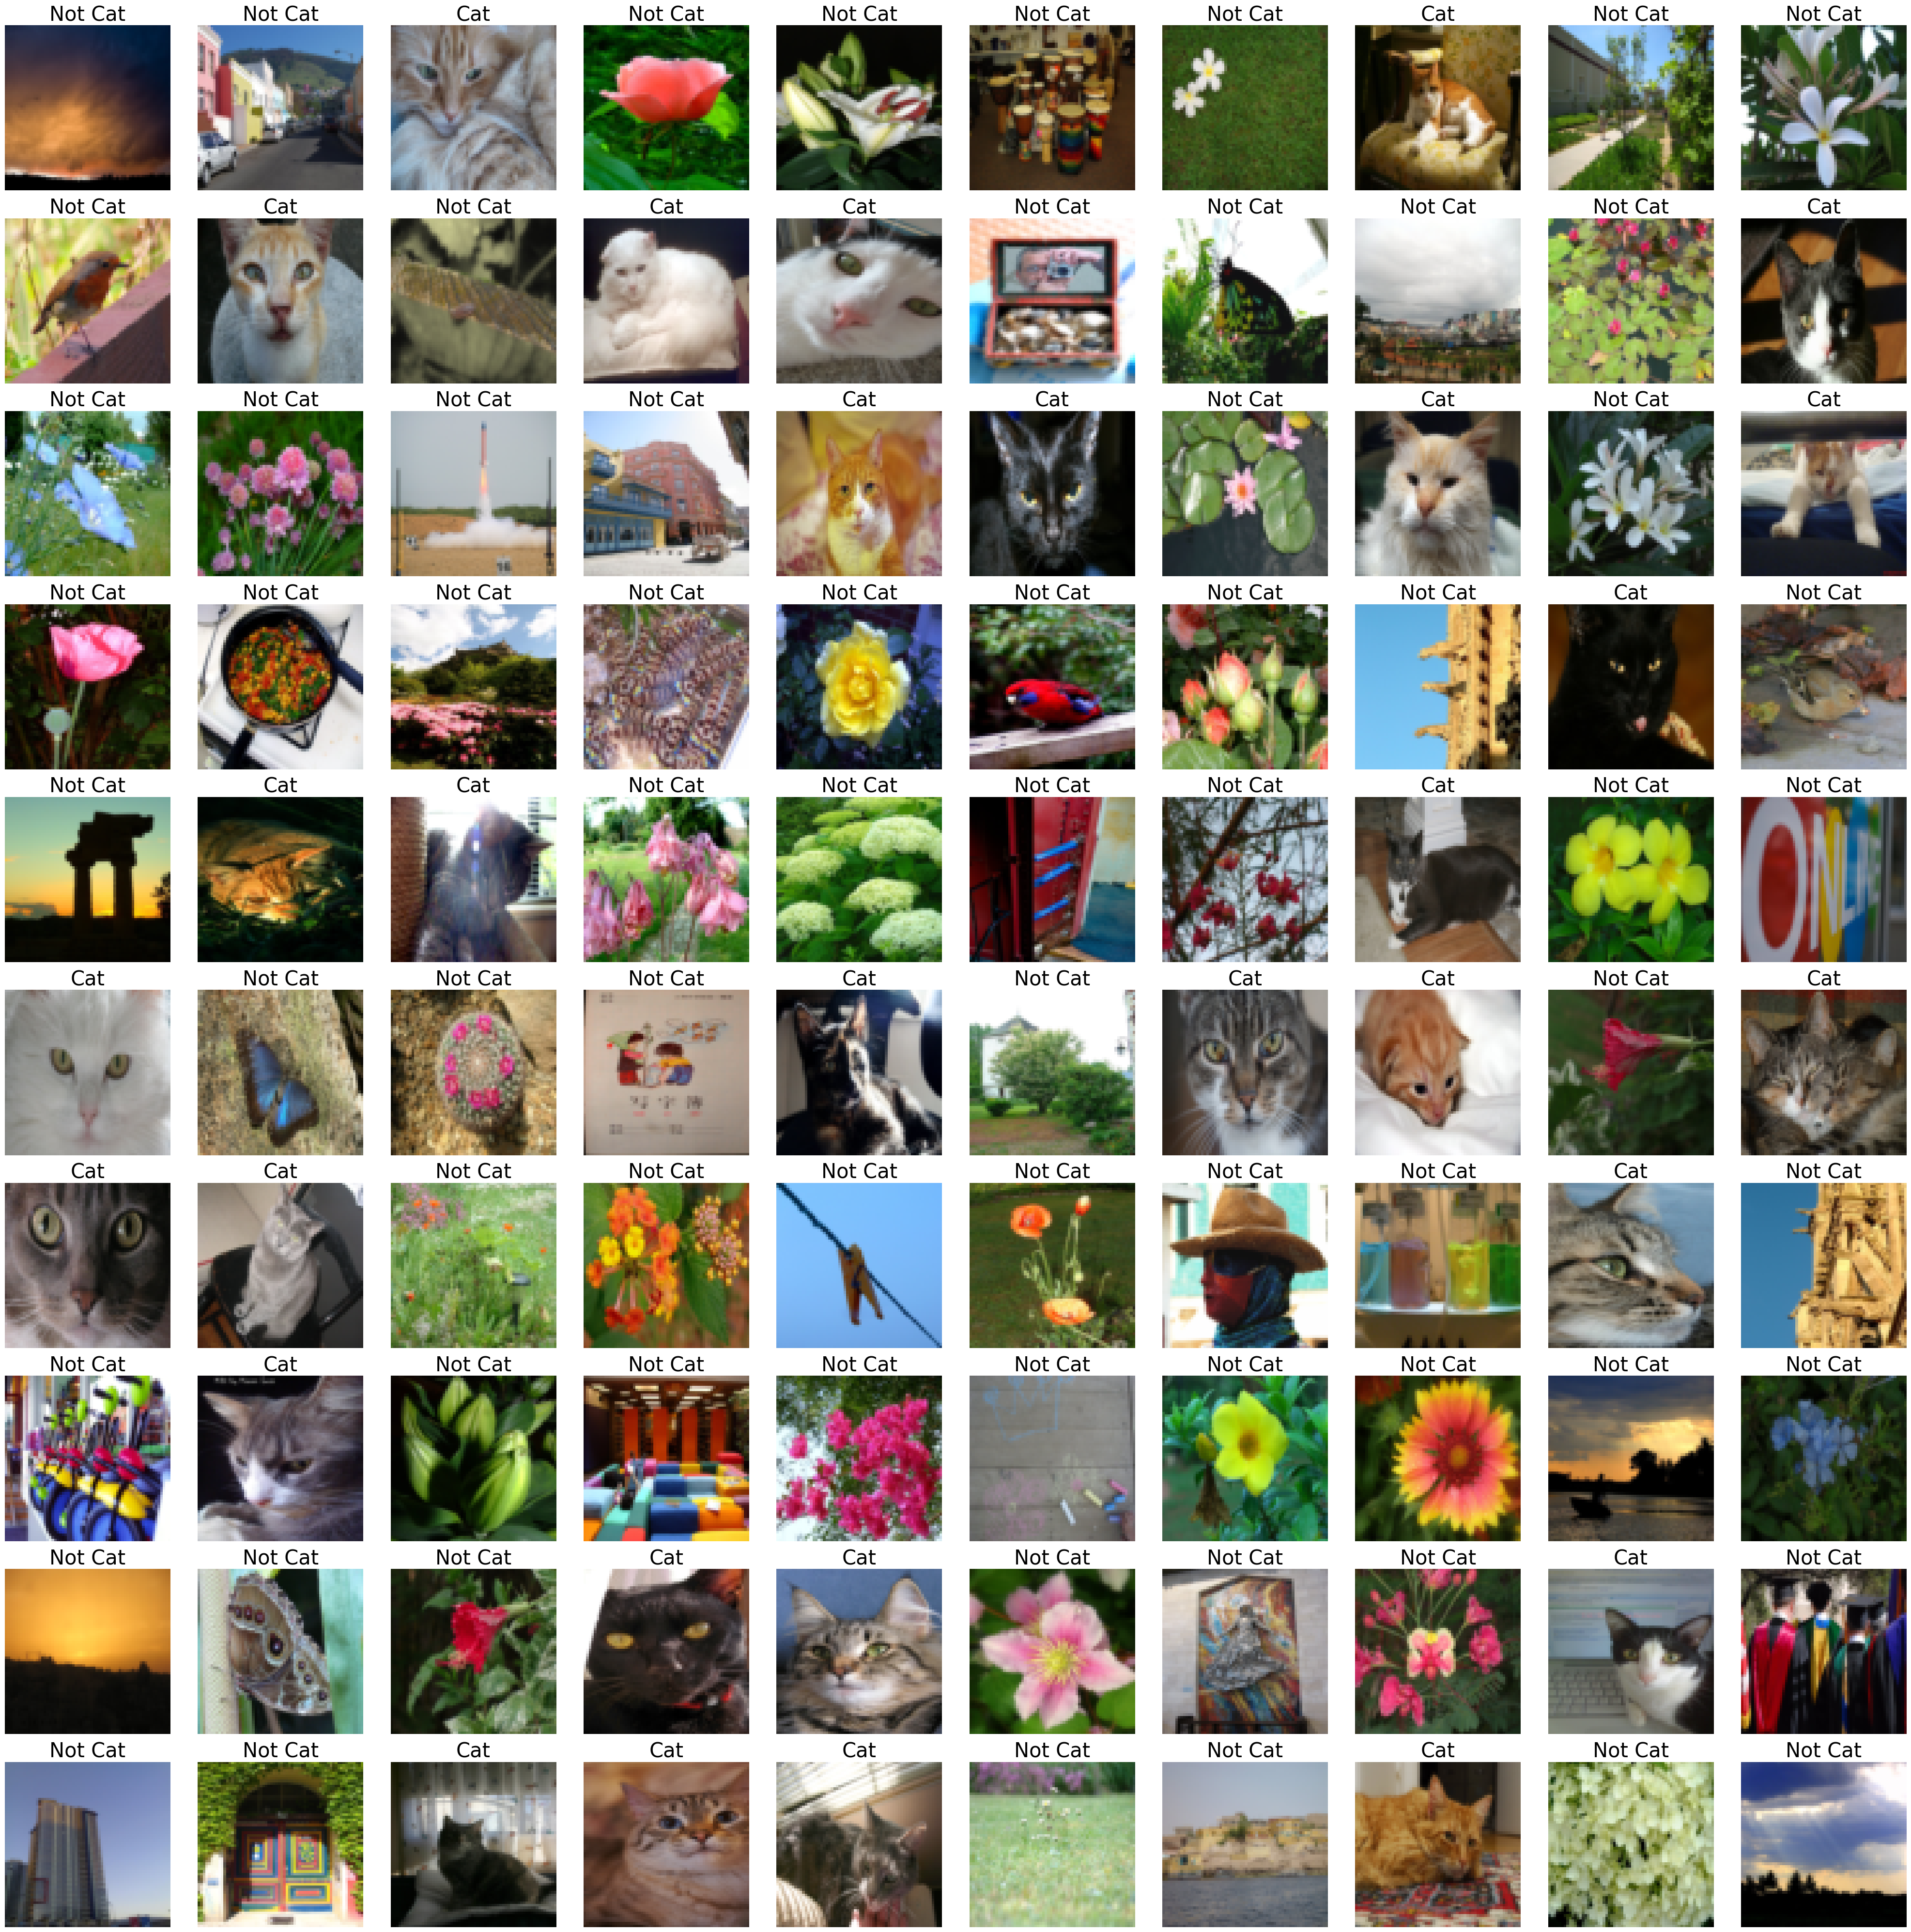

In [29]:
N = 100#int(input("How many Samples to see : "))
rows = int(np.ceil(np.sqrt(N)))
cols = int(np.ceil(N/rows))

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(rows*4, cols*4))
ax = ax.flatten()
for i in range(len(ax)):
    ax[i].axis('off')
    ax[i].imshow(X_train_set[i])
    is_cat = "Cat" if y_train[0,i] == 1 else "Not Cat"
    ax[i].set_title(label=f'{is_cat}', fontsize=30)
plt.tight_layout()

## **Shapes and Dimensions**

In [30]:
m_train = X_train_set.shape[0]
m_test = X_test_set.shape[0]
len_px, high_px = X_train_set.shape[1], X_train_set.shape[2]

print("Number of Training Example : ", str(m_train))
print("Number of Test Example :  ", m_test)
print(f"Size of The Images : ({len_px} , {high_px})")
print("Shape of X_Train_set : ", X_train_set.shape)
print("Shape of X_test_set : ", X_test_set.shape)
print("Shape of y_train : ", y_train.shape)
print("Shape of y_test : ", y_test.shape)

Number of Training Example :  209
Number of Test Example :   50
Size of The Images : (64 , 64)
Shape of X_Train_set :  (209, 64, 64, 3)
Shape of X_test_set :  (50, 64, 64, 3)
Shape of y_train :  (1, 209)
Shape of y_test :  (1, 50)


## **Reshape**

In [31]:
X_train = X_train_set.reshape(m_train, -1).T
X_test = X_test_set.reshape(m_test, -1).T

print("Shape of X_Train : ", X_train.shape)
print("Shape of X_test : ", X_test.shape)
print("Shape of y_train : ", y_train.shape)
print("Shape of y_test : ", y_test.shape)

Shape of X_Train :  (12288, 209)
Shape of X_test :  (12288, 50)
Shape of y_train :  (1, 209)
Shape of y_test :  (1, 50)


## **Rescale/Normalize**
<p>It is simpler, more convenient and works as well as Standardization(z-score Normalization)
    to <strong>Divide all the rows by 255</strong></p>

In [32]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

print("X_train_scaled (min, max) = ({}, {})".format(X_train_scaled.min(), X_train_scaled.max()))
print("X_test_scaled (min, max) = ({}, {})".format(X_test_scaled.min(), X_test_scaled.max()))

X_train_scaled (min, max) = (0.0, 1.0)
X_test_scaled (min, max) = (0.0, 1.0)


## **Model Architecture**

![Model Architecture](./architecture.jpg)

## **Building Part of The Algorithm**
1.sigmoid Function<br>
2.Initialize paramters<br>
3.Forward and backward Propagation<br>
4.Optimization algorithm<br>
5.prediction<br>

In [33]:
def sigmoid (z):
    """
    Compute the sigmoid of
    args:
    z -- A Scalar of Numpy array of any size
    returns:
    s -- sigmoid(z)
    """
    epsilon = 1e-15
    s = 1 / (1 + np.exp(-z + epsilon))
    return s

In [34]:
def initialize_to_zero (dim):
    """
    creates a vector of zeros with size (dim , 1) for paramters w and set scalar b to zero
    args:
    dim -- number of length * height of the image
    returns:
    w -- weights parameters with size (dim * 1)
    b -- bias , scalar (float)
    """
    w = np.zeros((dim, 1))
    b = 0.0
    return w, b

In [35]:
def propagation (w, b, X, y):
    """
    Uses Forward propagation to compute prediction a & backward propagation to compute gradient of loss function with
    respect to w and b
    args:
    w -- weights paramters of size (n , 1)
    b -- scalar (float)
    X -- Input Matrix of size (n , m)
    y -- True Label containing (0, 1)
    returns:
    grads -- a dictionary containing gradients of cost function with respect to weights and bias
        (dw -- gradient of the cost function with respect to w thus is the same shape as w)
        (db -- gradient of the cost function wtih respcet to b thus is the same shape as b)
    cost -- Negative log-likelyhood
    """
    m = X.shape[1]
    z = np.dot(w.T, X) + b
    a = sigmoid(z)
    epsilon = 1e-15
    loss = y * np.log(a + epsilon) + (1 - y ) * np.log(1 - a + epsilon)
    cost = (-1/m) * np.sum(loss)

    dz = a - y
    dw = (1/m) * (X @ dz.T)
    db = (1/m) * np.sum(dz)

    grads = {"dw":dw,
             "db":db}
    return grads, cost

In [36]:
def optimize (w, b, X, y, num_iterations=100, alpha=0.009, print_cost=False, tolerance=1e-6):
    """
    args:
    w ndarray (n, 1)
    b scalar (float)
    X ndarray (n , m)
    y ndarray (1, m)
    returns:
    params -- a dictionary containing weights (w ndarray (n , 1) and bias (scalar))
    grads  -- a dictionary containing gradients of cost function with respect to weights and bias
              (dw gradient of the cost function with respect to w - thus the same shape as w)
              (db gradient of the cost function with respect to b - thus the same shape as b)
    cost -- a list containing all cost computed during optimization - use this list for learning curve
    """
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    costs = list()

    for i in range(num_iterations):
        grads, cost = propagation(w,b,X,y)

        dw = grads.get("dw")
        db = grads.get("db")

        w = w - alpha * dw
        b = b - alpha * db

        if i % 100 == 0:
            costs.append(cost)

        if print_cost:
            if i % np.ceil(num_iterations / 100) == 0:
                print(f"Iteration {i:5d} : Cost = {cost:8.4f}")

        if len(costs) >= 2 and np.abs(costs[-1] - costs[-2]) < tolerance:
            print(f"Early Convergance at Iteration {i:5d} : Cost = {cost : 8.4f}")
            break

    params = dict(w=w, b=b)
    grads = dict(dw=dw, db=db)
    return params, grads, costs

In [37]:
def predict(w,b,X):
    """
    w ndarray (n , 1)
    b scalar (float)
    X ndarray (n , m)
    returns:
    y_prediction ndarray (1,m) with values {0,1}
    """
    
    z = np.dot(w.T, X) + b # (1,m)
    a = sigmoid(z) #(1,m)

    y_prediction = (a >= 0.5).astype(int)


    return y_prediction

In [38]:
def model (X_train, y_train, X_test, y_test, num_iterations=100, alpha=0.009, print_cost=False, tolerance=1e-8):
    """
    X_train ndarray (n , m_train)
    y_train ndarray (1 , m_train)
    X_test  ndarray (n , m_test )
    y_test  ndarray (1 , m_test )
    returns:
    d : a dictionary containing models informations
    """
    m , n = X_train.shape[1], X_train.shape[0]
    w , b = initialize_to_zero(n)
    
    params, grads, costs = optimize(w, b, X_train, y_train, num_iterations, alpha, print_cost, tolerance)
    w = params.get('w')
    b = params.get('b')
    
    y_predict_train = predict(w, b, X_train)
    y_predict_test = predict(w, b, X_test)

    train_accuracy = 100 - np.mean(np.abs(y_predict_train - y_train)) * 100 
    test_accuracy = 100 - np.mean(np.abs(y_predict_test - y_test)) * 100
    print(f"Training Accuracy = {train_accuracy:3f} %")
    print(f"Test Accuracy = {test_accuracy:3f} %")

    d = dict(w = w, 
             b = b, 
             costs = costs, 
             y_predict_train = y_predict_train, 
             y_predict_test = y_predict_test,
             learning_rate = alpha,
             num_iterations = num_iterations)
    return d

In [40]:
logistic_regression_model = model(X_train_scaled, y_train, X_test_scaled, y_test, 100000, alpha=0.005, print_cost=True)

Iteration     0 : Cost =   0.6931
Iteration  1000 : Cost =   0.2148
Iteration  2000 : Cost =   0.1356
Iteration  3000 : Cost =   0.0983
Iteration  4000 : Cost =   0.0767
Iteration  5000 : Cost =   0.0626
Iteration  6000 : Cost =   0.0528
Iteration  7000 : Cost =   0.0456
Iteration  8000 : Cost =   0.0401
Iteration  9000 : Cost =   0.0357
Iteration 10000 : Cost =   0.0322
Iteration 11000 : Cost =   0.0293
Iteration 12000 : Cost =   0.0268
Iteration 13000 : Cost =   0.0248
Iteration 14000 : Cost =   0.0230
Iteration 15000 : Cost =   0.0214
Iteration 16000 : Cost =   0.0201
Iteration 17000 : Cost =   0.0189
Iteration 18000 : Cost =   0.0178
Iteration 19000 : Cost =   0.0169
Iteration 20000 : Cost =   0.0160
Iteration 21000 : Cost =   0.0152
Iteration 22000 : Cost =   0.0145
Iteration 23000 : Cost =   0.0139
Iteration 24000 : Cost =   0.0133
Iteration 25000 : Cost =   0.0128
Iteration 26000 : Cost =   0.0123
Iteration 27000 : Cost =   0.0118
Iteration 28000 : Cost =   0.0114
Iteration 2900